<a href="https://colab.research.google.com/github/dinusha94/Machine-learning/blob/master/digit_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf gdrive/My\ Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [0]:
!pip install tensorflow-gpu==1.15 
!pip install keras

In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [4]:
!gsutil cp -r /content/gdrive/My\ Drive/train.npz /content/

Copying file:///content/gdrive/My Drive/train.npz...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      


In [0]:
import os
import sys
import random
import pandas as pd
import cv2
import numpy as np      
import matplotlib.pyplot as plt
from scipy import misc
import PIL

l = np.load('train.npz')

# See what's in here
#print (l.files)

# Parse data
train_img = l['data_img']
train_label = l['data_labels']


train_label = np.array(train_label)


# reconstruct images
image_data_list=[]
frame = 0
for im in train_img:
    input_img = im.reshape(64, 28)
    #cv2.imwrite("training_data/"+str(frame)+".jpg", input_img)
    image_data_list.append(input_img)
    frame += 1


img_data = np.array(image_data_list)
#img_data = img_data.astype('float32')



def build_synth_data(data,labels,dataset_size):
    
    #Define synthetic image dimensions
    synth_img_height = 28
    synth_img_width = 196
    
    #Define synthetic data
    synth_data = np.ndarray(shape=(dataset_size,synth_img_height,synth_img_width),
                           dtype=np.float32)
    
    #Define synthetic labels
    synth_labels = [] 
    
    #For a loop till the size of the synthetic dataset
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        num_digits =  random.randint(1,7)
        
        #Randomly sampling indices to extract digits + labels afterwards
        s_indices = [random.randint(0,len(data)-1) for p in range(0,num_digits)]
        
        #stitch images together
        new_image = np.hstack([img_data[index] for index in s_indices])
        
        
        #stitch the labels together
        new_label =  [train_label[index] for index in s_indices]
        
        
        #Loop till number of digits - 5, to concatenate blanks images, and blank labels together
        for j in range(0, 7-num_digits):
            new_image = np.hstack([new_image,np.zeros(shape=(64,28))])
            new_label.append(10) #Might need to remove this step
        
        #Resize image
        new_image = cv2.resize(new_image, (196,28), interpolation = cv2.INTER_AREA)
        img2 = cv2.normalize(new_image,None,90,120,cv2.NORM_MINMAX)
        blurImg = cv2.blur(img2,(2,2))  
        #Assign the image to synth_data
        synth_data[i,:,:] = blurImg
        
        #Assign the label to synth_data
        synth_labels.append(tuple(new_label))
        
    
    #Return the synthetic dataset
    return synth_data,synth_labels



#Building the training dataset
X_synth_train,y_synth_train = build_synth_data(img_data,train_label,60000)
#Building the test dataset
X_synth_test,y_synth_test = build_synth_data(img_data,train_label,20000)















(array([25.]), array([2.]), array([18.]), array([29.]), array([0.]), array([22.]), array([33.]))


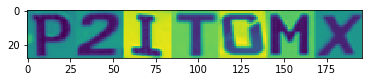

In [43]:

k = 13
print(y_synth_train[k])
plt.figure()
plt.imshow(X_synth_train[k])



In [7]:
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils


Using TensorFlow backend.


In [0]:
possible_classes = 37

def convert_labels(labels):
    
    #As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    #Each digit array will be of shape (60000,11)
    
    #Code below could be better, but cba for now. 
    
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))  
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig5_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig6_arr = np.ndarray(shape=(len(labels),possible_classes))
    

    for index,label in enumerate(labels):
        
        #Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        dig5_arr[index,:] = np_utils.to_categorical(label[5],possible_classes)
        dig6_arr[index,:] = np_utils.to_categorical(label[6],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr,dig5_arr,dig6_arr]

    
train_labels = convert_labels(y_synth_train)
test_labels = convert_labels(y_synth_test)

In [0]:
np.shape(train_labels[0])

(90000, 37)

In [0]:
def prep_data_keras(img_data):
    
    #Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data),196,28,1)
    
    #Converting everything to floats
    img_data = img_data.astype('float32')
    
    #Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data

train_images = prep_data_keras(X_synth_train)
test_images = prep_data_keras(X_synth_test)

In [0]:
np.shape(train_images)

(60000, 196, 28, 1)

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Building the model

batch_size = 128
nb_classes = 37
nb_epoch = 25

#image input dimensions
img_rows = 196
img_cols = 28
img_channels = 1

#number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

#defining the input
inputs = Input(shape=(img_rows,img_cols,img_channels))

#Model taken from keras example. Worked well for a digit, dunno for multiple
cov = Convolution2D(16,kernel_size=(3, 3),border_mode='same')(inputs)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size, strides=(2,2))(cov)
#cov = Dropout(0.25)(cov)

cov = Convolution2D(32,kernel_size=(3, 3))(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size, strides=(2,2))(cov)
#cov = Dropout(0.25)(cov)

cov = Convolution2D(64,kernel_size=(3, 3))(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size, strides=(2,2))(cov)


cov_out = Flatten()(cov)


#Dense Layers
cov2 = Dense(1024, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



#Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)
c5 = Dense(nb_classes, activation='softmax')(cov2)
c6 = Dense(nb_classes, activation='softmax')(cov2)

#Defining the model
model = Model(input=inputs,output=[c0,c1,c2,c3,c4,c5,c6])

adm = adam(lr=0.0001)
#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer=adm,metrics=['accuracy'])

checkpoint = ModelCheckpoint("seqence_wights.h5", monitor='val_loss', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto', period=1)

#Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,nb_epoch=120,verbose=1,
          validation_data=(test_images, test_labels), callbacks=[checkpoint])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, kernel_size=(3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 20000 samples
Epoch 1/120




60000/60000 [==============================] - 25s 409us/step - loss: 17.2663 - dense_2_loss: 3.5452 - dense_3_loss: 3.3653 - dense_4_loss: 3.0274 - dense_5_loss: 2.6103 - dense_6_loss: 2.1301 - dense_7_loss: 1.6032 - dense_8_loss: 0.9847 - dense_2_acc: 0.0510 - dense_3_acc: 0.1706 - dense_4_acc: 0.3066 - dense_5_acc: 0.4397 - dense_6_acc: 0.5851 - dense_7_acc: 0.7199 - dense_8_acc: 0.8597 - val_loss: 15.0583 - val_dense_2_loss: 3.4913 - val_dense_3_loss: 3.1919 - val_dense_4_loss: 2.6687 - val_dense_5_loss: 2.1459 - val_dense_6_loss: 1.6609 - val_dense_7_loss: 1.1902 - val_dense_8_loss: 0.7094 - val_dense_2_acc: 0.0682 - val_dense_3_acc: 0.1845 - val_dense_4_acc: 0.3205 - val_dense_5_acc: 0.4545 - val_dense_6_acc: 0.5897 - val_dense_7_acc: 0.7261 - val_dense_8_acc: 0.8614

Epoch 00001: val_loss improved from inf to 15.05825, 

In [0]:
predictions = model.predict(test_images)

In [12]:
np.shape(predictions)

(7, 20000, 37)

In [13]:
np.shape(test_labels)

(7, 20000, 37)

In [16]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,7):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 7:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/140000.0
    global_accuracy = global_sequence_counter/20000.0
    
    return ind_accuracy,global_accuracy
ind_acc,glob_acc = calculate_acc(predictions,test_labels)

print("The individual accuracy is {} %".format(ind_acc*100))
print("The sequence prediction accuracy is {} %".format(glob_acc*100))

The individual accuracy is 99.28857142857143 %
The sequence prediction accuracy is 95.56 %


In [17]:
#Printing some examples of real and predicted labels
for i in random.sample(range(0,20000),7):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,7):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [8, 5, 20, 10, 10, 10, 10]
Predicted labels: [8, 5, 20, 10, 10, 10, 10]

Actual labels: [11, 10, 10, 10, 10, 10, 10]
Predicted labels: [11, 10, 10, 10, 10, 10, 10]

Actual labels: [13, 10, 10, 10, 10, 10, 10]
Predicted labels: [13, 10, 10, 10, 10, 10, 10]

Actual labels: [1, 10, 16, 10, 10, 10, 10]
Predicted labels: [1, 10, 16, 10, 10, 10, 10]

Actual labels: [31, 20, 10, 10, 10, 10, 10]
Predicted labels: [31, 20, 10, 10, 10, 10, 10]

Actual labels: [13, 33, 6, 10, 10, 10, 10]
Predicted labels: [13, 33, 6, 10, 10, 10, 10]

Actual labels: [10, 26, 27, 13, 8, 26, 10]
Predicted labels: [10, 26, 27, 13, 8, 26, 10]



5488
(7, 1, 37)
Predicted labels: [25, 9, 2, 10, 1, 10, 10]



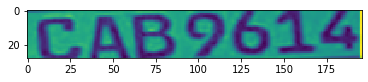

In [46]:
im = cv2.imread('CAB9614_2.jpg', 0)

new_image = cv2.resize(im, (196,28), interpolation = cv2.INTER_AREA)
img2 = cv2.normalize(new_image,None,90,120,cv2.NORM_MINMAX)
blurImg = cv2.blur(new_image,(2,2)) 

print(blurImg.size)
img_data = blurImg.reshape(1,196,28,1)
#Converting everything to floats
img_data = img_data.astype('float32')   
#Normalizing values between 0 and 1
img_data /= 255


predictions = model.predict(img_data)
print(np.shape(predictions))

predicted_labels = []
 
for j in range(0,7):
  predicted_labels.append(np.argmax(predictions[j]))
        
print("Predicted labels: {}\n".format(predicted_labels))

plt.imshow(blurImg)
plt.show()

